# Importamos Librerías

In [38]:
import requests
import os
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

# Cargamos Dataset

In [17]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv"
filename = os.path.basename(url)

save_dir = os.path.join(os.path.pardir, "data", "raw")  # ../data/raw
save_path = os.path.join(save_dir, filename)

os.makedirs(os.path.dirname(save_path), exist_ok=True)

response = requests.get(url)
with open(save_path, 'wb') as f:
    f.write(response.content)

print(f"Archivo guardado en: {save_path}")

Archivo guardado en: ../data/raw/housing.csv


In [18]:
# Ruta relativa al archivo desde src/
csv_path = os.path.join(os.path.pardir, "data", "raw", "housing.csv")

# Cargar el dataset en una variable (DataFrame)
total_data = pd.read_csv(csv_path)

total_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Verificamos las columnas del dataset

In [19]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Tenemos 9 variables numéricas sin valores nulos.

## Eliminamos Duplicados

In [20]:
total_data.drop_duplicates()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


No hay valores duplicados.

## Eliminamos Columnas

Dado que sólo nos interean las columnas Latitude, Longitude y MedInc, nos eliminamos las demás columnas del dataset.

In [21]:
total_data.drop(["HouseAge", "AveRooms", "AveBedrms","Population","AveOccup","MedHouseVal"], axis = 1, inplace = True)
total_data.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


## Comprobación de los datos en Clusters

<Axes: xlabel='Longitude', ylabel='Latitude'>

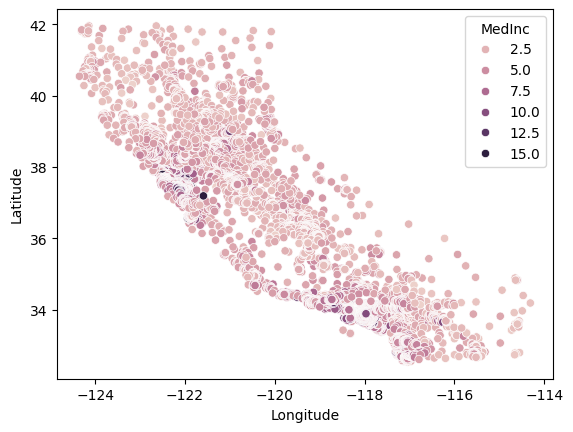

In [22]:
sns.scatterplot(data = total_data, x = 'Longitude', y = 'Latitude', hue = 'MedInc')

In [23]:
total_data.describe()

,MedInc,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000
mean,3.870671,35.631861,-119.569704
std,1.899822,2.135952,2.003532
min,0.499900,32.540000,-124.350000
25%,2.563400,33.930000,-121.800000
50%,3.534800,34.260000,-118.490000
75%,4.743250,37.710000,-118.010000
max,15.000100,41.950000,-114.310000


Vemos que todas las variables parecen tener valores coherentes.

## Dividimos los datos en conjunto de entrenamiento y pruebas

In [24]:
num_variables = ["Longitude", "Latitude", "MedInc"]

X = total_data[num_variables]
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)

## Guardamos los datasets

In [25]:
X_train.to_excel("../data/processed/X_train.xlsx", index = False)
X_test.to_excel("../data/processed/X_test.xlsx", index = False)

# Construir un K-Means

In [26]:
model = KMeans(n_clusters=6, random_state=42, n_init=10)
model.fit(X_train)

,n_clusters,6
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


Creamos una nueva columna en el dataset para almacenar el cluster al que pertenece cada casa.

In [ ]:
X_train = X_train.copy()
X_test = X_test.copy()

X_train['cluster'] = model.predict(X_train)
X_test['cluster'] = model.predict(X_test)

cluster
2    5628
4    3919
3    3024
5    2251
0    1348
1     342
Name: count, dtype: int64


,Longitude,Latitude,MedInc,cluster
14196,-117.03,32.71,3.2596,2
8267,-118.16,33.77,3.8125,2
17445,-120.48,34.66,4.1563,0
14265,-117.11,32.69,1.9425,2
2271,-119.80,36.78,3.5542,0


In [29]:
print(X_train['cluster'].value_counts())

X_train.head()

cluster
2    5628
4    3919
3    3024
5    2251
0    1348
1     342
Name: count, dtype: int64


,Longitude,Latitude,MedInc,cluster
14196,-117.03,32.71,3.2596,2
8267,-118.16,33.77,3.8125,2
17445,-120.48,34.66,4.1563,0
14265,-117.11,32.69,1.9425,2
2271,-119.80,36.78,3.5542,0


Graficamos los datos de latitude y longitude en función a sus clusters.

<Axes: xlabel='Longitude', ylabel='Latitude'>

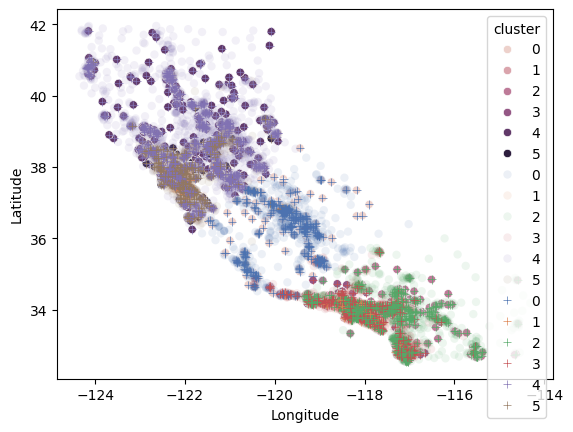

In [28]:
sns.scatterplot(
    data=X_test,
    x="Longitude",
    y="Latitude",
    hue="cluster",
)
sns.scatterplot(data = X_train, x = "Longitude", y = "Latitude", hue = "cluster", palette = "deep", alpha  = 0.1)
sns.scatterplot(data = X_test, x = "Longitude", y = "Latitude", hue = "cluster", palette = "deep", marker = "+")

<Axes: xlabel='Longitude', ylabel='MedInc'>

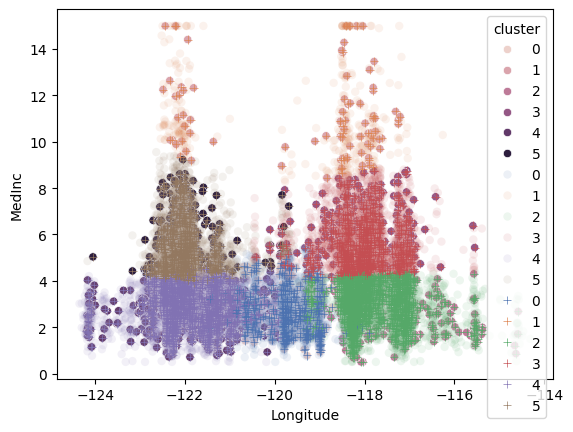

In [30]:
sns.scatterplot(
    data=X_test,
    x="Longitude",
    y="MedInc",
    hue="cluster",
)
sns.scatterplot(data = X_train, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep", alpha  = 0.1)
sns.scatterplot(data = X_test, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep", marker = "+")

# Entrenamiento de un Modelo de Clasificación Supervisado

## Creamos los dataset

In [31]:
# x_train_knn con las 3 variables de X_train
x_train_knn = X_train[num_variables]

# x_train_knn con las 3 variables de X_train
x_test_knn = X_test[num_variables]

# y_train con únicamente la target, cluster, del X_train
y_train = X_train["cluster"]

# y_test con únicamente la target, cluster, del X_test
y_test = X_test["cluster"]

## Guardamos los datos

In [32]:
x_train_knn.to_excel("../data/processed/x_train_knn.xlsx", index = False)
x_test_knn.to_excel("../data/processed/x_test_knn.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

## Implementamos el Knn

In [34]:
accuracy_results = []

model = KNeighborsClassifier(
        n_neighbors=5, 
        metric='euclidean', 
        weights='distance',
)
model.fit(x_train_knn, y_train)
y_pred = model.predict(x_train_knn)
accuracy_results.append(accuracy_score(y_train, y_pred))


y_pred_test = model.predict(x_test_knn)
accuracy_results.append(accuracy_score(y_test, y_pred_test))


print("Accuracy:", accuracy_results)
print("Mejor Accuracy:", max(accuracy_results))

Accuracy: [1.0, 0.9920058139534884]
Mejor Accuracy: 1.0


## Matriz de Confusión

Confusion matrix:
 [[ 333    0    0    0    5    0]
 [   0   85    0    2    0    2]
 [   0    0 1483    5    0    0]
 [   1    0    8  727    0    0]
 [   0    0    0    0  955    2]
 [   1    0    0    0    7  512]]


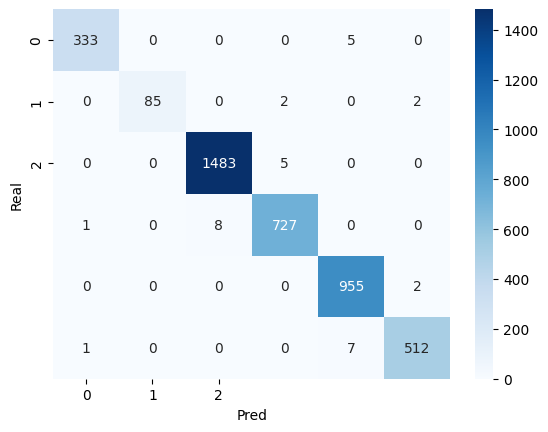

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

La matriz de confusión nos muestra que el modelo generaliza bastante bien, aunque tenemos un pequeño porcentaje de clases con falsos positivos y falsos negativos, con los errores concentrados en las clases 2 y 3, que se confunden entre sí.

Hay pocos falsos positivos y falsos negativos absolutos en las demás clases, lo que indica buena discriminación.

## Reporte de Clasificación

Classificaion report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       338
           1       1.00      0.96      0.98        89
           2       0.99      1.00      1.00      1488
           3       0.99      0.99      0.99       736
           4       0.99      1.00      0.99       957
           5       0.99      0.98      0.99       520

    accuracy                           0.99      4128
   macro avg       0.99      0.98      0.99      4128
weighted avg       0.99      0.99      0.99      4128



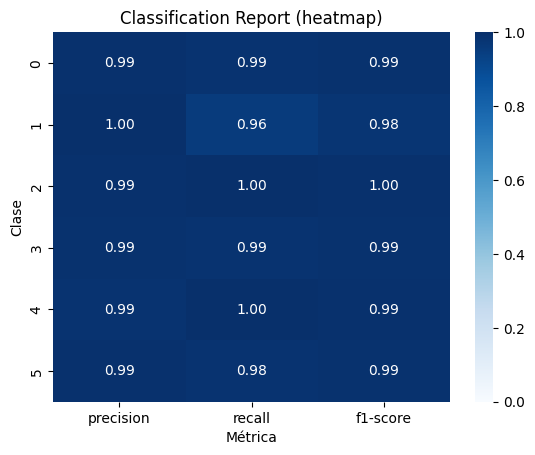

In [ ]:
cr = classification_report(y_test, y_pred_test)

rep = classification_report(
    y_test, y_pred_test,
    output_dict=True,
    target_names=["0", "1", "2", "3", "4", "5"]
)
total_data = pd.DataFrame(rep).T

heat = total_data.loc[["0", "1", "2", "3", "4", "5"], ["precision", "recall", "f1-score"]]

sns.heatmap(heat, annot=True, fmt=".2f", vmin=0, vmax=1, cmap="Blues")
plt.title("Classification Report (heatmap)")
plt.ylabel("Clase"); plt.xlabel("Métrica")
plt.show()

El modelo tiene un muy buen desempeño, con un error muy pequeño. La clase 1 es la única con recall ligeramente más bajo, lo que significa que el modelo no siempre detecta todas sus instancias.

# Guardamos el Modelo

In [39]:
pickle.dump(model, open("../models/kmeans.sav", "wb"))